# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Цель этого проекта, выявить от чего зависит цена недвижимости в Санкт-Петербурге и Ленинградской области.
Мы собираемся проверить, от каких факторов зависит стоимость квадратного метра и помочь бизнесу с выводами и принять верные решения.

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt



import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt

In [2]:
 df = pd.read_excel('real_estate_data_norm.xlsx')
display(df.head(5))

,Unnamed: 0,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,1,7,3350000,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,2,10,5196000,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,3,0,64900000,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />молодец, что делишь блоки загрузки библиотек и датасета, в случае необходимости добавления новых библиотек не придется загружать весь датасет заново и перезапускать проект целиком

Получаем общую информацию про датасет. Изучаем представленные типы данных и сравниваем их с аннотированными. Выявляем "проблемыне" места. 

In [61]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21556 entries, 0 to 23577
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            21556 non-null  int64         
 1   total_images          21556 non-null  int64         
 2   last_price            21556 non-null  int32         
 3   total_area            21556 non-null  float64       
 4   first_day_exposition  21556 non-null  datetime64[ns]
 5   rooms                 21556 non-null  int64         
 6   ceiling_height        21556 non-null  float64       
 7   floors_total          21556 non-null  int32         
 8   living_area           21556 non-null  float64       
 9   floor                 21556 non-null  int64         
 10  is_apartment          2644 non-null   float64       
 11  studio                21556 non-null  bool          
 12  open_plan             21556 non-null  bool          
 13  kitchen_area    

в процессе изучения приходим к выводу, что типы данных столбцов:

-  first_day_exposition  23699 non-null  object неверен, т к здесь, согласно описанию датафрейма, должен быть тип данных datetime;
- is_apartment          2775 non-null   object неверен, т к здесь, согласно описанию датафрейма, должен быть булев тип данных;
Исправим выяленные проблемы в процессе предобработки.

Кроме того, в таблице 23699 строк и таким образом, выявлены пропуски в столбцах: 

ceiling_height        14504 строк высота потолков можно заменить на медианное значение
floors_total          23613 строк всего этажей в доме нецелесообразно дополнять, т к пропусков немного
living_area           21796 строк жилая площадь в квадратных метрах (м²) можно заменить на медианное значение для данной квартиры
is_apartment          2775  строк апартаменты (булев тип) дозаполнить возможно, если принять во внимание, что апартаменты начинаются от пределенной площади

kitchen_area          21421 строк площадь кухни в квадратных метрах (м²) можно заменить на медианное значение для данной квартиры
balcony               12180 строк число балконов отсутствие данных заменим на 0, т к скорее всего, в квартире балкона нет
airports_nearest      18157 строк расстояние до ближайшего аэропорта в метрах - скорее всего, рядом нет аэропорта
cityCenters_nearest   18180 строк расстояние до центра города - пропуски целесообразно заменить на медианное значение
parks_around3000      18181 строк число парков в радиусе 3 км - отсутствие скорее всего, говорит о том, что рядом парка нет
parks_nearest         8079  строк расстояние до ближайшего парка м - если парк есть на расстоянии 3 км, а данных о расстоянии нет - имеет смысл заменить на медианное значение
ponds_around3000      18181 строк число водоёмов в радиусе 3 км - отсутствие скорее всего, говорит о том, что рядом водоема нет
ponds_nearest         9110  строк если водоём есть на расстоянии 3 км, а данных о расстоянии нет - имеет смысл заменить на медианное значение
days_exposition       20518 строк сколько дней было размещено объявление  - учитывая небольшое число пропусков, относительно общего кол-ва строчек, имеет смысл заменить на медианное значение

исследуем кол-во пропущенных значений для каждого столбца

In [4]:
display(df.head(5))

,Unnamed: 0,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,1,7,3350000,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,2,10,5196000,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,3,0,64900000,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [5]:
df.isna().sum()

Unnamed: 0                  0
total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


**Уже по первым колонкам мы видим что присутствуют как количественные так и качественные пропуски в колонках ниже** 

**Количественные:** 
ceiling_height, 
living_area, 
parks_nearest, 
ponds_nearest, 
days_exposition. 

**Качественные:** is_apartment

In [6]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

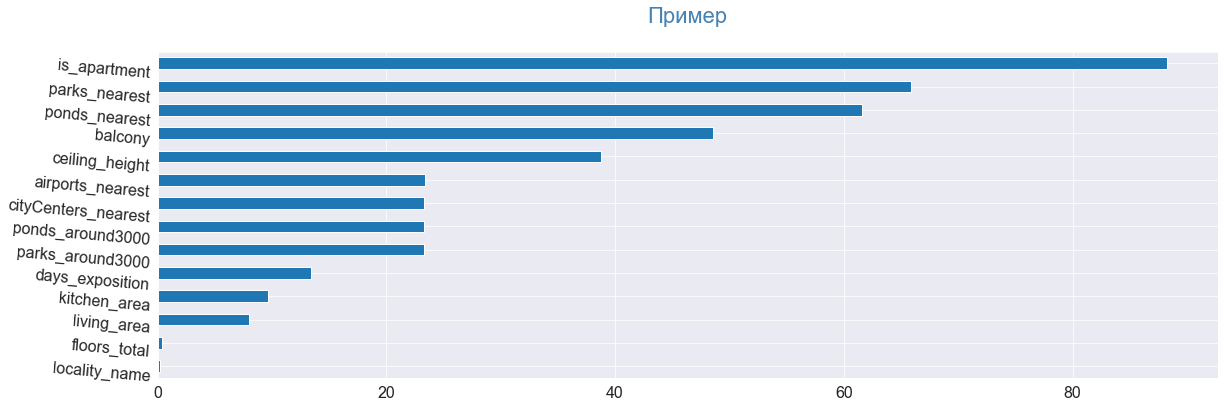

In [7]:
pass_value_barh(df)

In [8]:
 pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm').format("{:.2f}")

,0
Unnamed: 0,0.00
total_images,0.00
last_price,0.00
total_area,0.00
first_day_exposition,0.00
rooms,0.00
ceiling_height,39.00
floors_total,0.00
living_area,8.00
floor,0.00


приступаем к обработке пропущенных значений таблицы

df['balcony'] = df['balcony'].fillna(0)

df_median = df.groupby('cityCenters_nearest')['cityCenters_nearest'].median()
df['cityCenters_nearest'] = df['cityCenters_nearest'].fillna(df_median)
df.info()

для ознакомления со структурой данных, представленных в датафрейме, выведем на экран гистограммы отдельно  по каждому столбцу таблицы

### Предобработка данных

Начинаем работу с пропущенными значениями. Прежде всего, причины их появления могут быть различными:
- человеческий фактор
- отсутствие балкона в квартире, как такового
- отсутствие поблизости аэропорта, парка, водоёма
- технические проблемы сбора информации

для логичного представления информации в рамках проекта, представляется правильным последовательно обарботать каждый столбец, с оценкойй информации:
- изучать гистограммы и боксплот
- менять тип данных
- решать вопрос с пропусками

#### Столбец "total_images"

с учетом принятой концепции, напишем функцию, которая будет выводить нам блок информации и будем вызывать данную функцию для оценки каждого числового столбца по параметрам:
- описательные статистики
- график боксплот
- гистограмму


count    23699.000000
mean         9.858475
std          5.682529
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64

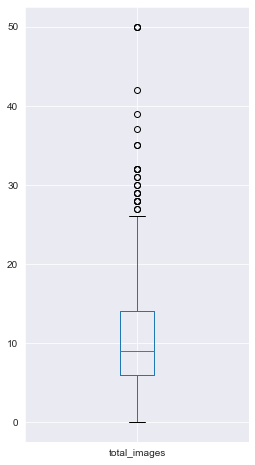

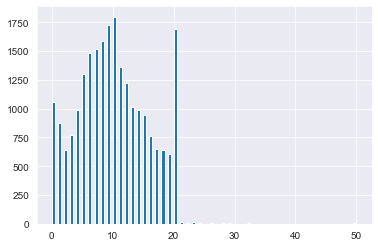

In [9]:
def basis_stat_f(target_column):
    display(df[target_column].describe())
    df.boxplot(column = target_column, figsize = (4,8))
    plt.show()
    df[target_column].hist(bins = 100)
    
basis_stat_f('total_images')

In [10]:
df.shape

(23699, 23)

In [11]:
#df = df.loc[(df['total_images'] < 27)]
df = df.query('total_images < 27')

In [12]:
df.shape

(23674, 23)

тип данных соответствует заявленному

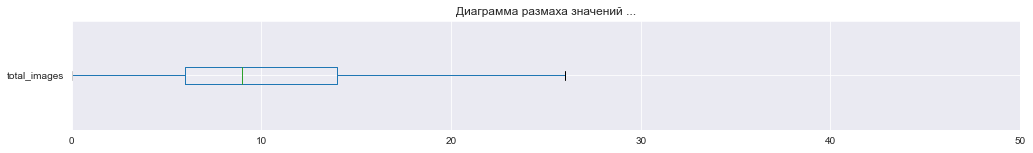

In [13]:
# check
# для примера горизонтальный вид диаграммы размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = df[['total_images']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений ...')
ax.set_xlim(0, 50);

#### Столбец "last_price"

изменяем тип данных на int, согласно заявленному в описании

In [14]:
df['last_price'] = df['last_price'].astype(int)

применяем функцию для выведения описательной статистики и графиков

count    2.367400e+04
mean     6.536793e+06
std      1.088963e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

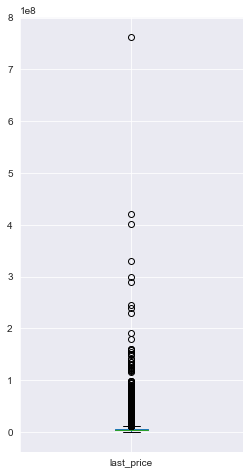

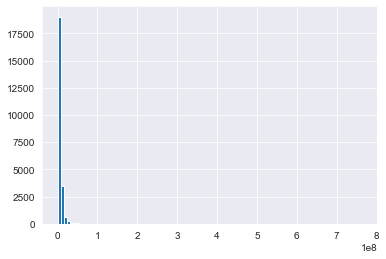

In [15]:

basis_stat_f('last_price')

last_price цена на момент снятия с публикации имеет довольно выраженный разброс: это отражает значительная разница между средним 6.54 и медианой 4.65, не смотря на то, что стандартное отклонение от среднего 1.0, разница среднее vs медиана довольно высока. Это говорит об широком диапазоне данного признака. От чего зависит цена на квартиры постараемся выяснить в рамках данного исследования. В тоже самое время, построенная гистограмма ничего нам не сказала про распределение признака, т к масштаб ее довольно маленький.
Из некорректного - мы видим,что есть случаи "около нуля", которых быть не может, т к цена квартиры не может стоить "ноль". Необходимо создать более детальную гистограмму, дабы разобраться с этими случаями. 

На гистограмме выше не большое кол-во значений расположено около нуля, т к масштаб не позволяет изучить детаоли. Изучим интересущие нас значения под масштабом

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

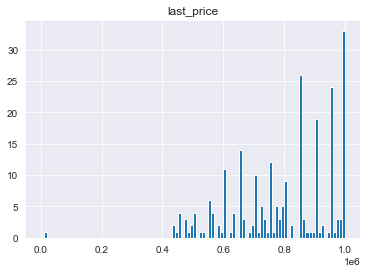

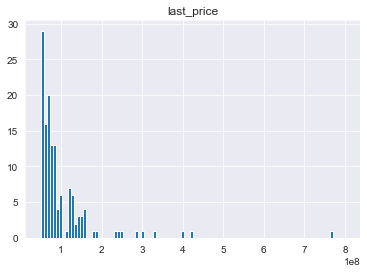

In [16]:
df.hist('last_price', bins = 100, range=(0, 1000000))
df.hist('last_price', bins = 100, range=(50000000, 800000000))

Мы видим, что есть "выбросы", от которых надо избавиться, чтобы данные были более равномерными. Для начала, избавимся от всего, что больше 200 000 000 и меньше 400 000.

In [17]:
df.shape


(23674, 23)

In [18]:

df = df.loc[(df['last_price'] > 400000)& (df['last_price'] < 200000000)]
#df = df.query('400000<last_price<100000000')
df = df.reset_index(drop = True)

#display(df.index)
#df['last_price'].describe()
 

In [19]:
df.shape

(23664, 23)

##### Итог обработки столбца: убрали 10 строк с выбросами

#### Столбец "total_area"

count    23664.000000
mean        60.171771
std         34.657135
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        631.200000
Name: total_area, dtype: float64

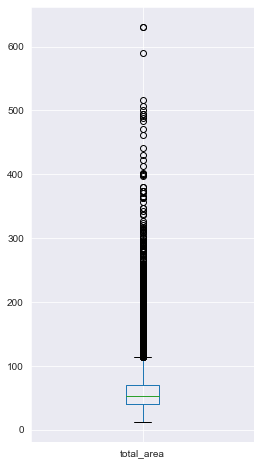

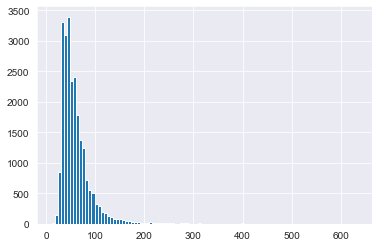

In [20]:
basis_stat_f('total_area')

##### в деталях изучим распределение данных в диапазоне 200-600 кв м

array([[<AxesSubplot:title={'center':'total_area'}>]], dtype=object)

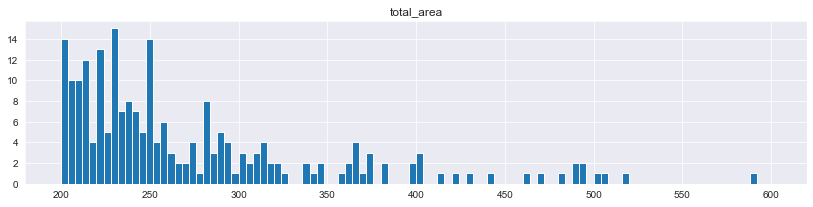

In [21]:
df.hist('total_area', bins=100, figsize=(14,3), range=(200, 600))

##### Из описательной статистики следует, что большая часть объектов недвижимости (75%) имеет площадь 70 кв метров. А т к масимальное значение объекта, представленного в датасете до 631 кв м, мы видим довольно значительные выбросы. Однако в целом, значения в выбросах распределены равномерно - это видно на пследней гистограмме, в которой мы предметно изучали распределение значение в диапазоне 200 - 600 кв метров.  На этой гистограмме видно, что минимальное кол-во объектов имеет площадь от 300 до 600 кв метров. Пока рабочая гипотеза такая: можно подумать об удалении выбросов свыше 300 кв м. Реализуем на практике.

In [22]:
df.shape

(23664, 23)

In [23]:
df = df.loc[(df['total_area'] < 300)]
#df = df.query('total_area<400')

#df = df.loc['total_area'] < 550
df = df.reset_index(drop = True)

In [24]:
df = df. loc[df['total_area'] < 500]

In [25]:
df.shape

(23607, 23)

##### Вывод: удалили по данной колонке 57 строк

#### Столбец "first_day_exposition"

##### данный столбец имеет тип данных object, однако должен иметь тип данных datetime. Исправим данную ситуацию. Соответственно, применить к нему нашу функцию с описательной статистикой и графиками мы не можем. 

In [26]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

удостоверяемся, что тип данных изменен на нужный нам

In [27]:
print(df['first_day_exposition'].head(5))

df.info()

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23607 entries, 0 to 23606
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            23607 non-null  int64         
 1   total_images          23607 non-null  int64         
 2   last_price            23607 non-null  int32         
 3   total_area            23607 non-null  float64       
 4   first_day_exposition  23607 non-null  datetime64[ns]
 5   rooms                 23607 non-null  int64         
 6   ceiling_height        14453 non-null  float64       
 7   floors_total          23521 non-null  float64       
 8   living_area           21717 non-null  float64       
 9   floor                 23607 non-null  int64         
 10  is_apartment          2769 non-null   float64       
 11  studio 

все в порядке: тип данных соответствует содержанию

#### Столбец "rooms"

данный столбец является критически важным для изучения стоимости квартиры, т к число комнат напрямую влияет на цену объекта. Изучим описательные статистики и построим диаграммы распределения данных, используя нашу функцию.

count    23607.000000
mean         2.057695
std          1.044576
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: rooms, dtype: float64

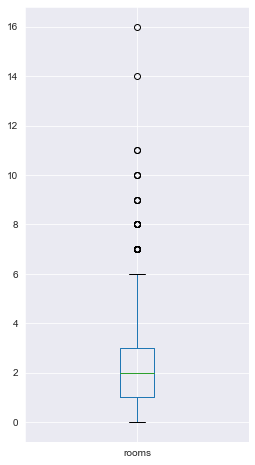

1     8044
2     7935
3     5797
4     1170
5      310
0      196
6       93
7       43
8        8
9        4
10       3
11       2
16       1
14       1
Name: rooms, dtype: int64

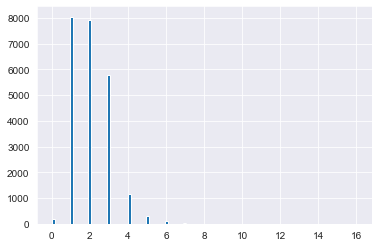

In [28]:
basis_stat_f('rooms')
df['rooms'].value_counts()

в целом данные распределны корректно, но внимание на себя обращает наличие объектов с 0 комнат - такого не может быть.  Большая же часть объектов (75%) имеет до 3 комнат. Выбросы начинаются от 8 комнат, т к там объектов всего 8, а 7 комнат - 43 объекта. Объектов с 0 комнат 196 штук. Таким образом, принимаем решение: удалить объекты с 0 комнат и более 7 комнат.

In [29]:
df['rooms']

0        3
1        1
2        2
3        3
4        2
        ..
23602    3
23603    3
23604    2
23605    2
23606    1
Name: rooms, Length: 23607, dtype: int64

In [30]:
df = df.loc[df['rooms'] < 8]

на этом этапе нам необходимо категоризировать квартиры по площади, т е принять условно какой площади, сколько комнат соответствует.

для начала разберемся с 0 комнат - смотрим какая площадь соотетствует этим данным.

In [31]:
df.query('rooms == 0')['total_area'].describe()

count    196.000000
mean      27.536276
std        8.368574
min       15.500000
25%       24.037500
50%       26.025000
75%       28.325000
max       98.400000
Name: total_area, dtype: float64

для анализа распределения площади внутри группы с нулевыми значениями, выведем площади на экран

In [32]:
df.query('rooms==0 and total_area>28.4')['total_area'].sort_values()

21213    28.50
2976     28.90
12937    29.00
19800    29.00
3418     29.00
2042     29.00
23500    29.00
15645    29.00
1163     29.00
18478    29.00
10371    29.10
7226     29.20
4949     29.30
7256     30.00
22775    30.00
1587     30.00
21965    30.10
5931     30.30
19659    30.50
13813    31.00
17883    31.00
6775     31.00
3131     31.00
1515     31.00
17957    31.00
15689    31.00
17734    31.10
6192     32.00
1164     32.00
15647    32.03
15637    32.20
6978     32.30
12178    32.40
18061    32.50
16452    32.80
21542    34.00
505      34.40
4662     35.00
833      35.00
9011     38.30
16063    42.10
7207     42.63
15254    43.30
9963     44.20
13557    58.40
21141    71.00
3440     73.60
20004    98.40
Name: total_area, dtype: float64

мы видим, что средняя площадь такой квартиры до 30 кв м, отклонение относительно среднего 8 кв м. Т е квартира до 30 кв = однокомнатная квартира. Сопоставим кол-во комнат и площадь квартиры, для чего воспользуемся циклом. Максимальный размер площади - 98.4 кв м - соответствует 4 комнатной квартире.

In [33]:
for n in range(1,5):
    print(f'{n} комнатная квартира:',df.query('rooms == @n')['total_area'].describe())
    print()

1 комнатная квартира: count    8044.000000
mean       37.588047
std         7.831294
min        12.000000
25%        32.500000
50%        36.530000
75%        41.000000
max       190.000000
Name: total_area, dtype: float64

2 комнатная квартира: count    7935.000000
mean       55.826239
std        13.098713
min        20.000000
25%        46.000000
50%        53.000000
75%        62.000000
max       196.000000
Name: total_area, dtype: float64

3 комнатная квартира: count    5797.000000
mean       77.653091
std        22.878113
min        40.100000
25%        62.000000
50%        72.900000
75%        86.900000
max       280.000000
Name: total_area, dtype: float64

4 комнатная квартира: count    1170.000000
mean      106.278564
std        39.785195
min        42.000000
25%        77.625000
50%        98.950000
75%       125.000000
max       295.000000
Name: total_area, dtype: float64



Пришло время категоризировать данные "нулевых" комнат, с учетом средней и стандартного отклонения:

Все что ниже 40 кв.м - сделаем 1 комнатными
от 40 до 60 кв.м - сделаем 2 комнатной
от 60 до 80 кв.м сделаем 3 комнатными
от 80 кв.м сделаем 4 комнатной
371 кв.м удалим, так как сложно понять сколько здесь комнат

за верхнюю границу примем площадь 125 кв метров (3 прецентиль 4-х комн квартир). Все, что выше этой площади - уберем, т к не понятно, сколько там комнат.

In [34]:
df.loc[(df['rooms'] == 0) & (df['total_area'] < 40)]== 1
df.loc[(df['rooms'] == 0) & (df['total_area'] > 40) & (df['total_area'] < 60)]== 2
df.loc[(df['rooms'] == 0) & (df['total_area'] > 60) & (df['total_area'] < 80)]== 3
df.loc[(df['rooms'] == 0) & (df['total_area'] > 80) & (df['total_area'] < 125)]== 4

,Unnamed: 0,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
20004,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [35]:
#df['rooms'] = df.query('rooms < 8')

##### Вывод: Итак, мы не удаляли строки, по-этому, переиндексировать ничего не надо. По-сути, на основе сопоставления кол-ва комнат и площади имеющихся квартир, мы категоризировали квартиры с кол-вом комнат в нашем датафрейме = 0, т е заменили нулевые значения, восполнив датафрейм. 

#### Столбец "ceiling_height"

В данной колонке довольно большое количество пропущенных значений. Эти пропуски вероятнее всего, появились, т к собственники квартир не считая данный параметр особенно важным, приняли решение, его не заполнять. По-этому, целесообразно заменить их медианными значениями.

count    14438.000000
mean         2.768687
std          1.262666
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

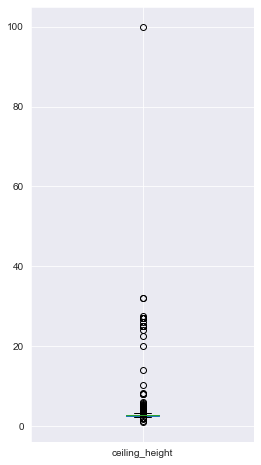

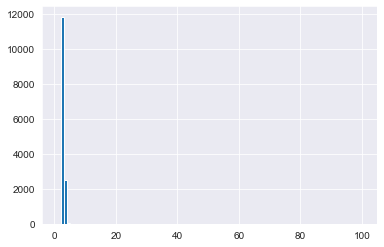

In [36]:
basis_stat_f('ceiling_height')

посчитаем кол-во уникальных зачений в выборке и более подробно исследуем выбросы - есть подозрение, что они связаны с тем, что не поставлен разделитель между метрами и сантиметрами.

In [37]:
df['ceiling_height'].value_counts(ascending=False)

2.50    3514
2.60    1645
2.70    1571
3.00    1104
2.80     992
        ... 
3.84       1
4.30       1
3.39       1
5.30       1
3.59       1
Name: ceiling_height, Length: 180, dtype: int64

<AxesSubplot:>

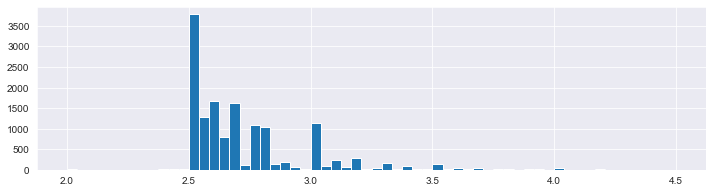

In [38]:
df['ceiling_height'].hist(figsize=(12,3), bins=60, range=(2.0, 4.5))


<AxesSubplot:>

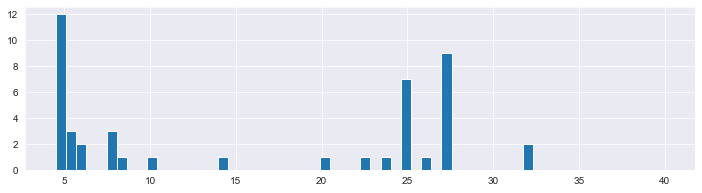

In [39]:
df['ceiling_height'].hist(figsize=(12,3), bins=60, range=(4.5, 40))

мы наблюдаем выбросы в размере высоты потолков. Попробуем сопоставить эти выбросы с другой информацией по квартире: сделаем срез по данным квартирам и решим что делать далее.

In [40]:
df.query('ceiling_height > 10.0')

,Unnamed: 0,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
352,355,17,3600000,55.2,2018-07-12,2,25.0,5.0,32.0,2,...,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
3132,3148,14,2900000,75.0,2018-11-12,3,32.0,3.0,53.0,2,...,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4622,4643,0,4300000,45.0,2018-02-01,2,25.0,9.0,30.0,2,...,7.0,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4854,4876,7,3000000,25.0,2017-09-27,0,27.0,25.0,17.0,17,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5053,5076,0,3850000,30.5,2018-10-03,1,24.0,5.0,19.5,1,...,5.5,NaN,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0
5223,5246,0,2500000,54.0,2017-10-13,2,27.0,5.0,30.0,3,...,9.0,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0
5644,5669,4,4400000,50.0,2017-08-08,2,26.0,9.0,21.3,3,...,7.0,2.0,Санкт-Петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0
5782,5807,17,8150000,80.0,2019-01-09,2,27.0,36.0,41.0,13,...,12.0,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
6217,6246,6,3300000,44.4,2019-03-25,2,25.0,5.0,31.3,5,...,5.7,NaN,Кронштадт,68923.0,50649.0,1.0,417.0,2.0,73.0,NaN
9338,9379,5,3950000,42.0,2017-03-26,3,25.0,5.0,30.0,2,...,5.2,NaN,Санкт-Петербург,11647.0,13581.0,0.0,NaN,0.0,NaN,NaN


после сопоставления площади квартиры и высоты потолков, приходим к выводу, что это обычные квартиры, а значит, надо работать с цифрами: скорее всего, наша гипотеза подтвердилась и в данных утерян разделитель.

In [41]:
#height_new = df.query('ceiling_height > 10.0').index
height_new = df.loc[(df['ceiling_height'] > 10)].index
df.loc[height_new, 'ceiling_height'] = df.loc[height_new, 'ceiling_height']/10



In [42]:
df.loc[height_new]['ceiling_height']
df['ceiling_height'].tail(10)

23597    2.86
23598     NaN
23599    2.75
23600     NaN
23601    2.60
23602    3.70
23603     NaN
23604     NaN
23605    3.00
23606    2.50
Name: ceiling_height, dtype: float64

удаляем выбросы

In [43]:
height_new = df.query('ceiling_height>35 or ceiling_height<1.9 or 7<ceiling_height<19').index
df.loc[height_new, 'ceiling_height']

3456      8.00
5687      1.20
5838      8.30
14998     1.40
15676     8.00
16865     1.75
17371     8.00
22220     1.03
22499     1.00
22777    10.00
Name: ceiling_height, dtype: float64

выбросы удаляем и проверяем

In [44]:
print("Кол-во строк перед удалением", len(df))
df.drop(height_new, inplace=True, axis=0)
print("Кол-во строк после удаления", len(df))

df.reset_index(inplace=True, drop=True)
display(df.tail())

Кол-во строк перед удалением 23588
Кол-во строк после удаления 23578


,Unnamed: 0,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23573,23694,9,9700000,133.81,2017-03-21,3,3.7,5.0,73.3,3,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23574,23695,14,3100000,59.00,2018-01-15,3,NaN,5.0,38.0,4,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23575,23696,18,2500000,56.70,2018-02-11,2,NaN,3.0,29.7,1,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23576,23697,13,11475000,76.75,2017-03-28,2,3.0,17.0,NaN,12,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0
23577,23698,4,1350000,32.30,2017-07-21,1,2.5,5.0,12.3,1,...,9.00,NaN,поселок Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df['ceiling_height'].describe()
df['ceiling_height'].value_counts().head(15)

2.50    3521
2.60    1646
2.70    1579
3.00    1104
2.80     992
2.55     980
2.75     910
2.65     676
3.20     273
3.10     202
2.90     162
2.56     139
3.30     139
3.50     124
2.57     103
Name: ceiling_height, dtype: int64

мы видим, что стандартное отклонение стало намного меньше, а данные корректнее. В целом, данные соответствуют реальности.

теперь решим вопрос с пропусками: для начала оценим их количество итого

In [46]:
df['ceiling_height'].isna().sum()
df['ceiling_height'].describe()

count    14428.000000
mean         2.723604
std          0.273053
min          2.000000
25%          2.510000
50%          2.650000
75%          2.800000
max          6.000000
Name: ceiling_height, dtype: float64

довольно много пропусков получилось. Будем заполнять медианными значениями: 2.65 метра.

In [47]:
df['ceiling_height'] = df['ceiling_height'].fillna(2.65)
display(df['ceiling_height'].isna().sum())
df['ceiling_height'].describe()

0

count    23578.000000
mean         2.695040
std          0.216586
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          6.000000
Name: ceiling_height, dtype: float64

In [48]:
df.shape

(23578, 23)

проблема с пропусками решена.

In [49]:
#df['ceiling_height'] = df['ceiling_height'].astype('int')

df['ceiling_height'].dtype


dtype('float64')

все в порядке: столбец подготовлен

In [50]:
# check
df['ceiling_height']

0        2.70
1        2.65
2        2.65
3        2.65
4        3.03
         ... 
23573    3.70
23574    2.65
23575    2.65
23576    3.00
23577    2.50
Name: ceiling_height, Length: 23578, dtype: float64

#### Столбец "floors_total"

count    23492.000000
mean        10.684659
std          6.595522
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

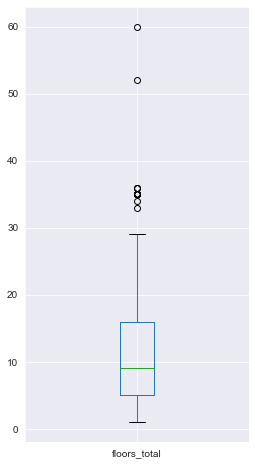

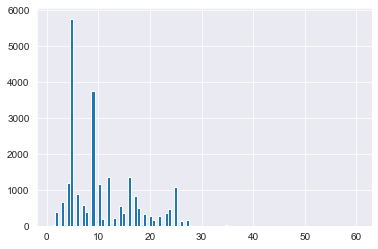

In [51]:
basis_stat_f('floors_total')

In [52]:
df['floors_total'].isna().sum()

86

пропущенных значений, относительно общего кол-ва немного. По-этому, удалим их и изменим тип на int.

In [53]:
df = df.dropna(subset=['floors_total'])
df['floors_total'] = df['floors_total'].astype('int')

In [54]:
df.tail()
df.isna().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23492 entries, 0 to 23577
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            23492 non-null  int64         
 1   total_images          23492 non-null  int64         
 2   last_price            23492 non-null  int32         
 3   total_area            23492 non-null  float64       
 4   first_day_exposition  23492 non-null  datetime64[ns]
 5   rooms                 23492 non-null  int64         
 6   ceiling_height        23492 non-null  float64       
 7   floors_total          23492 non-null  int32         
 8   living_area           21636 non-null  float64       
 9   floor                 23492 non-null  int64         
 10  is_apartment          2767 non-null   float64       
 11  studio                23492 non-null  bool          
 12  open_plan             23492 non-null  bool          
 13  kitchen_area    

##### столбец готов

#### Столбец "living_area"

count    21636.000000
mean        33.893180
std         19.433541
min          2.000000
25%         18.600000
50%         30.000000
75%         42.100000
max        250.000000
Name: living_area, dtype: float64

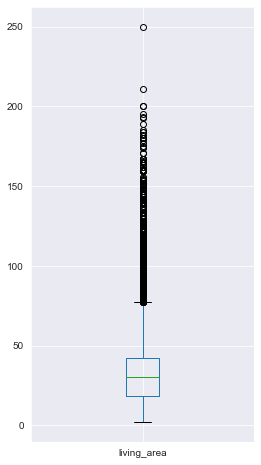

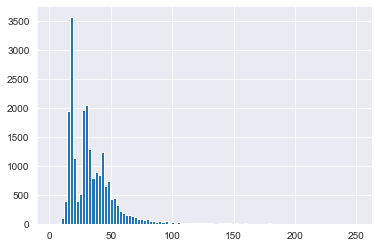

In [55]:
basis_stat_f('living_area')

In [56]:
df['living_area'].sort_values(ascending = True)

21646    2.0
13845    2.0
3224     3.0
23453    3.0
17492    5.0
        ... 
23521    NaN
23542    NaN
23549    NaN
23558    NaN
23576    NaN
Name: living_area, Length: 23492, dtype: float64

сразу откинем выбросы более 170 кв метров, как единичные случаи

In [57]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23492 entries, 0 to 23577
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            23492 non-null  int64         
 1   total_images          23492 non-null  int64         
 2   last_price            23492 non-null  int32         
 3   total_area            23492 non-null  float64       
 4   first_day_exposition  23492 non-null  datetime64[ns]
 5   rooms                 23492 non-null  int64         
 6   ceiling_height        23492 non-null  float64       
 7   floors_total          23492 non-null  int32         
 8   living_area           21636 non-null  float64       
 9   floor                 23492 non-null  int64         
 10  is_apartment          2767 non-null   float64       
 11  studio                23492 non-null  bool          
 12  open_plan             23492 non-null  bool          
 13  kitchen_area    

In [58]:
df = df.loc[(df['living_area'] < 170) & (df['living_area'] > 10)]

In [59]:
# check
df.shape

(21556, 23)

In [60]:
# check
df_check = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') 
df_check.info()
df_isna = df_check.query('airports_nearest.isna() | airports_nearest < 60000')
df_isna.info()

FileNotFoundError: [Errno 2] No such file or directory: '/datasets/real_estate_data.csv'

In [ ]:
# check
df_check = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') 
df_check.info()
df_isna = df_check[(df_check ['airports_nearest'] < 60000) | (df_check ['airports_nearest'].isna()) ]

df_isna.info()

In [ ]:
basis_stat_f('living_area')

изучая описательную статистику, приходим к выводу, что т к разброс признака от среднего значения велик (mean =    33.998806, std = 19.786539, 50% = 30.000000), целесообразно заполнение пропусков медианными значениями. Посчитаем кол-во пропущенных значений.

In [ ]:
df['living_area'].isna().sum()

заменяем пропуски и удостоверяемся, что все в порядке

In [ ]:
df['living_area'] = df['living_area'].fillna(value = 30)
df.info()

##### столбец готов

In [ ]:
df.query('total_area*0.9 <= (living_area + kitchen_area)')#.dropna()

Заполним ‘living_area’, ‘kitchen_area’ медианными значениями (так как стандартное отклонение >>1) с привязкой к ‘total_area’

In [ ]:
for item in ['living_area', 'kitchen_area']:
    df[item] = df[item].fillna(df.groupby('total_area')[item].transform('median'))

In [ ]:
df.isna().sum()

In [ ]:
df.query('total_area*0.9 <= (living_area + kitchen_area)')

In [ ]:
df.query('total_area*0.9 <= (living_area + kitchen_area)').dropna()

#### Столбец "floor"

In [ ]:
basis_stat_f('floor')

In [ ]:
df['floor'].isna().sum()

Пропусков нет, данные распределены равномерно, тип данных int - все верно. Столбец готов.

In [ ]:
# check
df.info()

#### Столбец "is_apartment "


Столбец с булевыми значениями и большим кол-вом пропусков. Изменим тип данных на bool и заполним пропуски.

In [ ]:
df['is_apartment'] = df['is_apartment'].astype('bool')
df['living_area'] = df['living_area'].fillna('False')

In [ ]:
df.info()

##### столбец готов

#### Столбец "studio" и Столбец "open_plan"

в обоих случаях мы видим, что пропусков нет, тип данных bool. Ничего делать не надо.

#### Столбец "kitchen_area"

In [ ]:
basis_stat_f('kitchen_area')

In [ ]:
df['kitchen_area'].isna().sum()

изучая описательную статистику, приходим к выводу, что т к разброс признака от среднего значения велик (mean =    10.49, std = 5.65, 50% = 9.1), целесообразно заполнение пропусков медианными значениями. Кол-во пропущенных значений велико 2216 (около 10% данных столбца). Тип данных правильный float64.

In [ ]:
df['kitchen_area'] = df['kitchen_area'].fillna(5.65)

In [ ]:
df['kitchen_area'].isna().sum()

In [ ]:
df.shape

In [ ]:
#df = df.dropna(subset=['kitchen_area'])

##### столбец готов

#### Столбец "balcony"

In [ ]:
basis_stat_f('balcony')

In [ ]:

df.fillna({
    'balcony': 0,

}, inplace=True)

пропусков нет, необходимо изменить тип данных на int. В остальном все в порядке.

In [ ]:
df['balcony'] = df['balcony'].astype('int64',  errors='ignore')
df.info()

#### Столбец "locality_name"

для начала изучим содержание столбца с точки зрения уникальных значений

In [ ]:
df['locality_name'].value_counts()
df['locality_name'].isna().sum()

Итак, у нас всего 48 пропусков - это немного. Посмотрим сколько уникальных значений в столбце, при этом уберем NaN и отсортируем значения сразу по алфавиту

In [ ]:
df['locality_name'].sort_values().unique()

In [ ]:
df.dropna(subset=['locality_name'], inplace=True)
df['locality_name']

проверяем на наличие явных дубликатов

In [ ]:
df.duplicated().sum()

явных дубликатов нет

при ручной обработке неявных дубликатов, обнаружено 2 варианта: слово поселок пишется с буквой е и ё; встречаются дубликаты с одной и той же смысловой нагрузкой: поселок и поселок городского типа. Приведем их к одному решению: заменим все буквы ё на е и пгт на поселок

In [ ]:
df['locality_name'] = df['locality_name'].str.replace('ё','е')
df['locality_name'] = df['locality_name'].replace({r'(\b)поселок городского типа(\b)':r'\1поселок\2'}, regex=True)

In [ ]:
df['locality_name'].sort_values().unique()

заполнять пропуски не представляется возможным, да это и нецелесообразно, ввиду того, что пропусков мало. 

In [ ]:
# check
df['locality_name'].nunique()

##### столбец готов


#### Столбец "airports_nearest "

In [ ]:
basis_stat_f('airports_nearest')

In [ ]:
df['airports_nearest'].isna().sum()

In [ ]:
df['airports_nearest'] = df['airports_nearest'].fillna(df.groupby(['locality_name'])\
                                                       ['airports_nearest'].transform('median'))

In [ ]:
df['airports_nearest'].isna().sum()

пропусков очень много. С учетом большого стандартного отклонения и распределения данных на гистограмме считаю, что пропуски целесообразно не трогать, т к для предсказательной модели важна точность данных. Населенных пунктов много и часть из них может просто находиться очень далеко от аэропорта. В случае наличия корреляяции между расстоянием до аэропорта и стоимостью объекта, заполение пропущенных значений медианными может привести к значительному искажению модели. Тип данных оставляем таким же.

#### Столбец "cityCenters_nearest "

In [ ]:
basis_stat_f('cityCenters_nearest')

другое дело - расстояние до центра. Данные распределены по иному, нежели с расстоянием до ближайшего аэропорта: на гистограме 2 пика, но данный расположены "компактно", что подтверждает описательная стистика. Тем не менее, с учетом размаха  стандартного отклонения, целесообразно пропущанные значения заменить медианными. Посмотрим на кол-во пропусков.

In [ ]:
df['cityCenters_nearest'].isna().sum()

In [ ]:
df['cityCenters_nearest'] = df['cityCenters_nearest'].fillna(df.groupby(['locality_name'])\
                                                             ['cityCenters_nearest'].transform('median'))

In [ ]:
df['cityCenters_nearest'].isna().sum()

In [ ]:
df['cityCenters_nearest'] = df['cityCenters_nearest'].astype('int', errors = 'ignore')

In [ ]:
df.info()

удалось заполнить с довольно высокой точностью 95% пропусков - отличный результат. Оставшиеся 5% трогать не станем, т к это может ухудшить предсказательнуюценность модели.

#### Столбцы "parks_around3000 " и "ponds_around3000"

Объединим столбцы в один раздел, т к в целом они схожи по смысловому наполнению. Оценим кол-во пропусков в каждом

In [ ]:
df['parks_around3000'].isna().sum()


In [ ]:
df['ponds_around3000'].isna().sum()

In [ ]:
df['parks_around3000'] = df['parks_around3000'].fillna(value = 0)
df['ponds_around3000'] = df['ponds_around3000'].fillna(value = 0)
df['parks_around3000'] = df['parks_around3000'].astype('int')
df['ponds_around3000'] = df['ponds_around3000'].astype('int')
df.info()


#### Столбцы "parks_nearest " и "ponds_nearest"

изучим данные столбцы в одном разделе, т к они близки по смысловому наполнению. Для начала, построим диаграммы и оценим как распределены данные в каждом столбце.

In [ ]:
basis_stat_f('parks_nearest')

In [ ]:
basis_stat_f('ponds_nearest')

В столбце ponds_nearest практически отсутствуют выбросы, чего нельзя сказать про столбец parks_nearest. Фактически у нас имеется всего 34-38% значений, но с учетом специфики столбцов, это говорит о том, что скорее водоёмов нет по-близости к данному объекту недвижимости. Именно этот факт является основной причиной пропусков в исселдуемых столбцах. С учетом сказанного выше,будем заполнять нулями.

In [ ]:
df['parks_nearest'] = df['parks_nearest'].fillna(value = 0)
df['ponds_nearest'] = df['ponds_nearest'].fillna(value = 0)
df['parks_nearest'] = df['parks_nearest'].astype('int64', errors='ignore')
df['ponds_nearest'] = df['ponds_nearest'].astype('int64', errors='ignore')
df.info()

##### столбцы готовы

#### Столбец "days_exposition "

In [ ]:
basis_stat_f('days_exposition')

In [ ]:
df.isna().sum()

с учетом распределения данных и большого кол-ва выбросов, попробуе заменить пропущенные значения в кол-ве 3157 штук на медиану, полученную путем группировки по локализации. ТАкже заменим тип данных на intenger.

In [ ]:
 #df['days_exposition'] = df['days_exposition'].fillna(df.groupby('locality_name')\['days_exposition'].transform('median'))

In [ ]:
df.isna().sum()

осталось минимальное кол-во пропущенных значений 76 штук,которые можно просто удалить

In [ ]:
#df = df.dropna(subset=['days_exposition'])
#df['days_exposition'] = df['days_exposition'].astype('int')
#df.isna().sum()

##### датасет подготовлен к исследовательскому анализу данных

In [ ]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных показателях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floor',
       'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

In [ ]:
# check
df.total_area.hist(bins = 150, figsize = (15,3));

In [ ]:
# check
df.total_area.hist(bins = 150, figsize = (15,3), range = (180,300));

In [ ]:
# check
df.rooms.value_counts().to_frame()

### Посчитайте и добавьте в таблицу новые столбцы

##### добавляем в таблицу столбец 'price_of_one_sqr' - цена одного квадратного метра

In [ ]:
df['price_of_one_sqr'] =  df ['last_price'] / df['total_area']
display(df['price_of_one_sqr'])

##### добавляем столбец "day_of_week" - день публикации объявления

In [ ]:
df['day_of_week'] = df['first_day_exposition'].dt.weekday
display(df['day_of_week'])

##### добавляем столбец "month_of_publication" -  - месяц публикации объявления


In [ ]:
df['month_of_publication'] = df['first_day_exposition'].dt.month
df['month_of_publication']

##### добавляем столбец "year_of_publication" -  - год публикации объявления

In [ ]:
df['year_of_publication'] = df['first_day_exposition'].dt.year
df['year_of_publication']

##### добавляем столбец 'type_of_floor' - тип этажа квартиры

In [ ]:
def type_of_floor (row):
    try:
        floors_total = row['floors_total']
        floor = row['floor']
        if floor == 1:
            return "первый"
        elif floor == floors_total:
            return "последний"
        else:
            return "другой"
    except:
        print('Введите еорректное значение')
    

In [ ]:
df['type_of_floor'] = df.apply(type_of_floor, axis = 1)

In [ ]:
df['type_of_floor']

##### добавляем столбец 'distance_before_center' - расстояние до центра города в километрах

In [ ]:
df['distance_before_center'] = (df['cityCenters_nearest']/1000).round()
df['distance_before_center']

### Проведите исследовательский анализ данных

#### Строим гистограммы по выбраным столбцам

    На этапе предобработки мы строили гистограмму, боксплот и изучали описательные статистики вызывая функцию. А сейчас построим гистограммы с учетом индивидуального масштаба графика и сделаем тоже самое с использованием цикла. 

Общая площадь большинства квартир колеблется в диапазоне  30-40 кв метров. Квартиры более 10 кв метров - небольшое кол-во случаев, относительно всей выборки.

In [ ]:
df['total_area'].hist(bins = 100, range=(0, 200))
plt.title('Общая площадь')
plt.xlabel('общая площадь')
plt.ylabel('кол-во случаев')

Жилая площадь большинства квартир имеет 2 пика: около 18 и 30 кв метров, в 3 раза реже встречаются квартиры около 40 кв метров.

In [ ]:
df['living_area'].hist(bins = 100, range=(0, 125))
plt.title('Жилая площадь')
plt.xlabel('жилая площадь')
plt.ylabel('кол-во случаев')

площадь кухни большинства квартир от 6 до 10 кв метров

In [ ]:
df['kitchen_area'].hist(bins = 100, range=(0, 30))
plt.title('Площадь кухни')
plt.xlabel('площадь кухни')
plt.ylabel('кол-во случаев')

Последняя известная цена большей части квартир около 4 00 000 рублей

In [ ]:
df['last_price'].hist(range = (400000, 10000000))
plt.title('Последняя цена')
plt.xlabel('последняя цена')
plt.ylabel('кол-во случаев')

в большей части квартир 1 - 2 комнаты

In [ ]:
df['rooms'].hist(bins = 20, range=(0, 10))
plt.title('Количество комнат')
plt.xlabel('кол-во комнат')
plt.ylabel('кол-во случаев')

высота потолков большей части квартир 2- 2.2 метра

In [ ]:
df['ceiling_height'].hist(range = (2, 4))
plt.title('Высота потолков')
plt.xlabel('Высота потолков, м')
plt.ylabel('кол-во случаев')

продаются преимущественно квартиры, распологающиеся на 4 этаже

In [ ]:
df['floor'].hist(bins = 100, range=(0, 30))
plt.title('Этаж')
plt.xlabel('этаж')
plt.ylabel('кол-во случаев')

In [ ]:
# check

df['floor'].hist(bins = 120, range=(0, 30))
plt.title('Этаж')
plt.xlabel('этаж')
plt.ylabel('кол-во случаев')

продаются преимущественно квартиры, распологающиеся в 5 этажных домах (возможно, это старые панельные хрущевки?)

In [ ]:
df['floors_total'].hist(bins = 20, range=(0, 40))
plt.title('Всего этажей')
plt.xlabel('всего этажей')
plt.ylabel('кол-во случаев')

большая часть выставленных на продажу квартир находится на удалении 11 км от центра города

In [ ]:
df['cityCenters_nearest'].hist(bins = 100 , range=(0, 50000))
plt.title('Удаленность от центра города')
plt.xlabel('удаленность от центра города, м')
plt.ylabel('кол-во случаев')

большая часть выставленных на продажу квартир находится на удалении 20 км от аэропорта

In [ ]:
df['airports_nearest'].hist(bins = 100 , range=(0, 80000))
plt.title('Удаленность от аэропорта')
plt.xlabel('удаленность от аэропорта, м')
plt.ylabel('кол-во случаев')

у большинства выставленных на продажу квартир нет по-близости парков, что характерно для районов хрущевок с плохо развитой инфраструктурой отдыха

In [ ]:
df['parks_nearest'].hist(bins = 30, range=(100, 2500) )
plt.title('Расстояние до ближайшего парка')
plt.xlabel('расстояние до ближайшего парка, м')
plt.ylabel('кол-во случаев')

продаются преимущественно квартиры, расположенные на последнем этаже, в меньшей степени - категория "другие", т.е. те, что расположены между 1 и последним этажом. Как правило, на первом этаже располагаются коммерческие помещения, возможно, с этим связано меньшая часть продаваемых объектов первого этажа.

In [ ]:
t_o_f = df.pivot_table(index = 'type_of_floor', values = 'floor')
display(t_o_f)
t_o_f.hist(bins = 20)
plt.title('Тип этажа квартиры')
plt.xlabel('категория типа')
plt.ylabel('кол-во случаев')

In [ ]:
data_pivot = df.pivot_table(index=['type_of_floor'],  aggfunc=['count'])
data_pivot['floor_cat_count'] = df.groupby('type_of_floor')['type_of_floor'].count()



In [ ]:
data_pivot.plot(y = 'floor_cat_count', kind = 'bar', grid = True)
plt.xlabel('Тип этажа')
plt.ylabel('Колчество наблюдений')

Преимущественно публикация объявления происходит во вторник и четверг

In [ ]:
df['day_of_week'].hist(bins = 20 )
plt.title('День недели публикации объявления')
plt.xlabel('день пн (0) - вс (6)')
plt.ylabel('кол-во случаев')

Преимущественно публикация объявлений о продаже происходит в период февраль - апрель, декабрь

In [ ]:
df['month_of_publication'].hist(bins = 30 )
plt.title('Месяц публикации объявления')
plt.xlabel('день янв (0) - дек (11)')
plt.ylabel('кол-во случаев')

аналогичную задачу удалось решить в цикле, если бы не пришлось подбирать для каждого графика индивидуальный масштаб. Тем не менее, для решения ряда задач, построение графика в цикле может существенно облегачать работу. Код ниже привожу в качестве своих размышлений ))

In [ ]:
for target_column in df[['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms',  'floor', 'floors_total', 'cityCenters_nearest', 'airports_nearest']]:
    display(df[target_column].describe())
    #df.boxplot(column = target_column, figsize = (4,8))
    #plt.show()
    df[target_column].hist(bins = 100)
    plt.show()


по 2 столбцам:
тип этажа квартиры («первый», «последний», «другой») object,
день и месяц публикации объявления datetime64, 
гистограммы никак не построишь, т к их можно построить только по типу int или float

In [ ]:
def diagram(target_column, x=4, y=8, b = 100, title = 'Гистограмма', xlabel = 'Гистограмма', ylabel = 'кол-во случаев'):
    display(df[target_column].describe())
    df.boxplot(column = target_column, figsize = (x,y))
    plt.show()
    df[target_column].hist(bins = b)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
diagram('floors_total', x = 10, y = 10, b = 50, title = 'Гистограмма', xlabel = 'Гистограмма', ylabel = 'кол-во случаев')
  

#### Изучаем длительность продажи квартиры

для начала, применим методики описательной статистики и построим графики боксплот и гистограмму

In [ ]:
display(df['days_exposition'].describe())
df.boxplot(column = 'days_exposition')
plt.show()
df['days_exposition'].hist(bins = 100, range = (0, 600), figsize = (20, 10))
plt.title('Длительность продажи квартиры')
plt.xlabel('длительность продажи, дней')
plt.ylabel('кол-во случаев')




исходя из данных описательной статистики и гистограммы, считаем, что квартира "в среднем"(по значениям медианы", продается 99 дней. Берем значение медианы, т к среднее 174.7 дня, имеет очень большой разброс данных, что видно исходя из значения отклонения от среднего в 209 дней. Соответсвенно, будем считать, что все, что меньше медианы 99 дн - "быстрые продажи". Вычислим max_lim уровень ящика boxplot, чтобы ответить на вопрос: "какие продажи можно считать необычно долгими?"

In [ ]:
q1 = df['days_exposition'].quantile(0.25)
q3 = df['days_exposition'].quantile(0.75)
max_lim = q3 + 1.5 * (q3-q1)
display(max_lim)

построим более точный график для изучения аномалий.Есть аномалии в виде выбросов в районе 50, 60 дней. Связываю с технической особенностью сервиса - сервис может автоматичсеки через заданный промежуток времени, если объеявление не пролонгированно, снимать его с публикации

In [ ]:
df['days_exposition'].hist(bins = 100, range = (0, 100), figsize = (20, 10))
plt.title('Длительность продажи квартиры')
plt.xlabel('длительность продажи, дней')
plt.ylabel('кол-во случаев')

##### итак, получается, что все продажи свыше 529,9 - необычно долгие продажи.

In [ ]:
# check
# Моды на реальных данных

try:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t') 
except:
    df_check = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
    
df_check['days_exposition'].value_counts().to_frame().head(20).plot(kind = 'barh', figsize = (15,6), rot = 0);

#### Изучаем факторы, влияющие на общую стоимость объекта

##### Постройте графики, которые покажут зависимость цены от указанных выше параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы.

Для решения данной задачи, будем последовательно сопоставлять стоимость объекта и указанные в задаче параметры. Таким образом, исследуем внутреннюю взаимосвязь между ними.

In [ ]:

display(df['last_price'].corr(df['total_area']))
df.plot(x='living_area', y='last_price', kind='scatter', grid=True, figsize=(14,7), alpha=0.5) 
plt.title('Взаимосвязь стоимости и стоимости квадратного метра')
plt.xlabel('общая площадь объекта')
plt.ylabel('стоимость объекта')


мы видим наличие довольно выраженной взаимосвязи между стоимостью объекта и общей площадью, коэф корреляции 0,71. Также видно , что цена зависит от общей площади только до определённого этапа. Начиная с площади 95-100 м2 зависимость сильно уменьшается и разброс цен становится ярко выраженным.

In [ ]:
display(df['last_price'].corr(df['living_area']))
df.plot(x='living_area', y='last_price', kind='scatter', grid=True, figsize=(14,7), alpha=0.5)
plt.title('Взаимосвязь стоимости и размера жилой площади')
plt.xlabel('размер жилой площади')
plt.ylabel('стоимость объекта')

также имеется зависимость между стоимотью кв метра и размера жилой площади. Однако, эта зависимость не сильно выражена (0.61)

In [ ]:
display(df['last_price'].corr(df['kitchen_area']))
df.plot(x='kitchen_area', y='last_price', kind='scatter', grid=True, figsize=(14,7), alpha=0.5)
plt.title('Взаимосвязь стоимости и размера площади кухни')
plt.xlabel('площадь кухни')
plt.ylabel('стоимость кв метра')

практически отсутствует взаимосвязь между стоимостью объекта и площадью кухни

In [ ]:
#Вычислим среднюю цену в каждой категории
cat_fl_mean = df.groupby('type_of_floor')['last_price'].mean()
cat_fl_mean.plot(x=cat_fl_mean.index, y=cat_fl_mean.values, kind='bar', grid=True, figsize=(6,5))
plt.title('Взаимосвязь стоимости и категории этажности')
plt.xlabel('категория этажности')
plt.ylabel('стоимость объекта')

зависимость стоимости и категориии этажа квартиры можно изучить на такой гистограмме. Можно сделать вывод, что наименьшей популярностью пользуется первый этаж.

In [ ]:
ds = df.pivot_table(index=['day_of_week'], values='last_price',  aggfunc=['mean', 'count', 'median'])
ds.plot(y='median', style='-')
display(ds)
plt.xlabel('День недели размещения объявления (0 = пн, 6 = вс)')
plt.ylabel('Цена')
plt.show

In [ ]:
ds = df.pivot_table(index=['month_of_publication'], values='last_price',  aggfunc=['mean', 'count', 'median'])
ds.plot(y='median', style='-')
display(ds)
plt.xlabel('Месяц размещения объявления (0 = пн, 6 = вс)')
plt.ylabel('Цена')
plt.show

Самые низкие цены на те объекты которые были размещены летом, пик призодится на июнь. Наибольшие цены приходятся на объявления размещённые весной с пиком в апреле.

In [ ]:
ds = df.pivot_table(index=['year_of_publication'], values='last_price',  aggfunc=['mean', 'count', 'median'])
ds.plot(y='median', style='-')
display(ds)
plt.xlabel('Месяц размещения объявления (0 = пн, 6 = вс)')
plt.ylabel('Цена')
plt.show

Мы видим полное отсутствие взаимосвязи между стоимостью квартиры и днем/месяцем/годом подачи объявления

###### ВЫВОД: Больше всего на стоимость квартиры влияет её площадь(прямопропорцианальная зависимость). Среднее влияние оказывает удаленность от центра(обратнопропорцианальная зависимость) и количество комнат (особенно хорошо видна прямопропорцианальная зависимость на отрезке 1-3 комнаты, все что выше уже не коррелирует). Также надо отметить, что есть зависимость от этажа - первый этаж мало кто любит и цена его существенно отличается от остальных; люди предпочитают не первый и не последний этаж - его цена выше(но на немного выше последнего). Дата же размещения не оказывает влияния на цену. С 2014 года произошло снижение стоимости жилья, которое восстанавливалось постепенно к 2019 году.

##### Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name.

In [ ]:
mean_10_city = df.groupby('locality_name')['price_of_one_sqr'].agg(['count', 'mean'])\
.sort_values(by = 'count', ascending = False).head(10)
mean_10_city.columns = ['flats', 'price_of_one_sqr']
mean_10_city.reset_index(inplace=True)




display(mean_10_city)




###### Вывод: самая низкая стоимость недвижимости в Выборге = 58365 руб/кв метр, самая высокая стоимость недвижимости в Санкт-Петербурге = 113554 руб/кв метр.

In [ ]:
mean_10_city.pivot_table(index = 'locality_name', values = 'price_of_one_sqr', aggfunc = 'mean').sort_values(by='price_of_one_sqr', ascending=False)


In [ ]:
print('Город с максимальной стоимостью квадратного метра:')
display( mean_10_city.loc[mean_10_city['price_of_one_sqr'] == mean_10_city['price_of_one_sqr'].max()])

print('Город с минимальной стоимостью квадратного метра:')
display( mean_10_city.loc[mean_10_city['price_of_one_sqr'] == mean_10_city['price_of_one_sqr'].min()])

##### Выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

In [ ]:
mean_km_spb = df.loc[df['locality_name'] == 'Санкт-Петербург',['last_price','distance_before_center']].reset_index(drop = True)

display(mean_km_spb.head(10))

In [ ]:
mean_km_spb = mean_km_spb.pivot_table(index = 'distance_before_center', values = 'last_price', aggfunc = 'mean')
mean_km_spb.plot(kind='bar', grid=True, figsize=(14,8))
plt.title('Средняя стоимость км от центра Санкт-Петербурга')
plt.xlabel('расстояние до центра (км)')
plt.ylabel('средняя стоимость, млн руб.')

###### Вывод: стоимость км в центре города самая высокая. В целом, чем дальше от центра города, тем стоимость недвижимости ниже.

### Общий вывод

Для анализа был дан ДатаСет с информацией по продаже квартир. Состоял из 22 колонок и 23699 строк. 7 колонок не пригодились (total_images, open_plan, balcony, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest).
В процессе предобработки было удалено 2519 строки, то есть осталось 21180 строк, удалено 10.6% данных.
Cтолбец first_day_exposition приведен к типу datetime64
В столбце ceiling_height заменили большую часть на медиану. Здесь были обнаружены ошибочно введенные значения, в которых справа присутствовал лищний ноль,- исправили
В столбцах living_area и kitchen_area произведена замена медианами. 
В числовых столбцах заменены типы на int.
В столбце days_exposition пропуски заполненны медианами в зависимости от населенного пункта
Обрезаны сильные выбросы в столбцах где они имели место.
Удалено 2 дубликата.

В столбцах с расстояниями заменяли пропуски средними значениями и при обработке было выясненно , что полностью невозможно заполнить столбцы с расстояниями: airports_nearest, parks_nearest, ponds_nearest и особенно важный cityCenters_nearest. Единственная возможность заполнить пропуски в airports_nearest - заполнить средней или медианой всего столбца - но в таком случае при решении задач дальнейшего анализа это сильно может исказать результаты! Поэтому при анализе, там где будет затронут столбец airports_nearest, будем довольствоваться 16519 (-22%!) строками, где присутствуют значения в этом столбце.

По заданию было добавлено 7 столбцов, в которых были подсчитаны дополнительные параметры:
цена квадратного метра;
день недели, месяц и год публикации объявления;
этаж квартиры; варианты — первый, последний, другой;
соотношение жилой и общей площади, а также отношение площади кухни к общей.
Был проведен анализ и сделаны выводы по заданным вопросам:

Больше всего квартир с площадями 30-46 кв.м - это, похоже, самые популярные 1 и 2-х комнатные. Далее идут скорее всего 2 и 3 комнатные с площадью до 75 кв.м.

Самые популярные квартиры - 1 комнатная(чуть больше 8000) и 2 комнатные(около 8000). 3 комнатных тоже довольно много - чуть меньше 6000, ну а дальше кол-во сильно сокращаетя.
Больше всего квартир с высотой потолков 250 - 300 см, подавляющее большинство почти половина с высотой 265 см.

Факторы больше всего влияющие на стоимость квартиры: Больше всего на стоимость квартиры влияет её площадь(прямопропорцианальная зависимость). Среднее влияние оказывает удаленность от центра(обратнопропорцианальная зависимость) и количество комнат (особенно хорошо видна прямопропорцианальная зависимость на отрезке 1-3 комнаты, все что выше уже не коррелирует). Также надо отметить, что есть зависимость от этажа - первый этаж мало кто любит и цена его существенно отличается от остальных; люди предпочитают не первый и не последний этаж - его цена выше(но на немного выше последнего).

Подавляющее большинство квартир продается в Питере - 14381, а цена около 113236/кв.м. Помимо Питера в Топ10 входят: поселок Мурино, поселок Шушары, Всеволожск, Пушкин, Колпино, поселок Парголово, Гатчина, деревня Кудрово, Петергоф с ценами 68634 - 103434 руб/кв.м.

Самая низкая стоимость недвижимости в Гатчине = 68634 руб/кв метр, самая высокая стоимость недвижимости в Санкт-Петербурге = 113236 руб/кв метр.
Стоимость км в центре города самая высокая. В целом, чем дальше от центра города, тем стоимость недвижимости ниже, что вполне укладываестя в логику.


In [ ]:
# check
import seaborn as sns

In [ ]:
# check
sns.pairplot(df[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']])
plt.gcf().set_size_inches(12,12);


In [ ]:
# check
data = df.copy()

data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='last_price' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — цена трешки')


data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter', 
        y='last_price' , x='living_area', alpha=0.5, figsize=(15,8), c = 'r', s = 4)
plt.title('Диаграмма рассеяния — Жилая площадь — цена трешки');